# 머신 러닝 교과서 - 파이토치편

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/ml-with-pytorch/blob/main/ch18/ch18_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

## 패키지 버전 체크

check_packages.py 스크립트에서 로드하기 위해 폴더를 추가합니다:

In [1]:
import sys

# 코랩의 경우 깃허브 저장소로부터 python_environment_check.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/python_environment_check.py
else:
    sys.path.insert(0, '..')

--2023-10-12 14:11:15--  https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/python_environment_check.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1629 (1.6K) [text/plain]
Saving to: ‘python_environment_check.py’

python_environment_ 100%[===================>]   1.59K  --.-KB/s    in 0s      

2023-10-12 14:11:15 (24.7 MB/s) - ‘python_environment_check.py’ saved [1629/1629]



권장 패키지 버전을 확인하세요:

In [2]:
from python_environment_check import check_packages


d = {
    'torch': '1.8.0',
    'torch_geometric': '2.0.2',
    'numpy': '1.21.2',
    'matplotlib': '3.4.3',
}

check_packages(d)

[OK] Your Python version is 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
[FAIL]: torch_geometric is not installed and/or cannot be imported.
[OK] torch 2.0.1+cu118
[OK] numpy 1.23.5
[OK] matplotlib 3.7.1


# 18장 - 그래프 구조 데이터의 의존성 감지를 위한 그래프 신경망 (Part 2/2)

- 파이토치 지오메트릭 라이브러리를 사용하여 GNN 구현하기
- 기타 GNN 층 및 최근 개발 사항
  - 스펙트럼 그래프 합성곱
  - 풀링
  - 정규화
  - 그외 고급 그래프 신경망
- 요약

In [3]:
from IPython.display import Image
%matplotlib inline

## 파이토치 지오메트릭 라이브러리를 사용하여 GNN 구현하기

In [4]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.6 MB/s eta 0:00:00


In [5]:
import torch
import torch.nn.functional as F
import torch.nn as nn


from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_add_pool

import numpy as np

In [6]:
dset = QM9('.')
len(dset)

Extracting ./raw/qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!


130831

In [7]:
data = dset[0]
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])

In [8]:
data.z

tensor([6, 1, 1, 1, 1])

In [9]:
data.new_attribute = torch.tensor([1, 2, 3])
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5], new_attribute=[3])

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data.to(device)
data.new_attribute.is_cuda

True

In [11]:
class ExampleNet(torch.nn.Module):
    def __init__(self,num_node_features,num_edge_features):
        super().__init__()
        conv1_net = nn.Sequential(nn.Linear(num_edge_features, 32),
                                  nn.ReLU(),
                                  nn.Linear(32, num_node_features*32))
        conv2_net = nn.Sequential(nn.Linear(num_edge_features,32),
                                  nn.ReLU(),
                                  nn.Linear(32, 32*16))
        self.conv1 = NNConv(num_node_features, 32, conv1_net)
        self.conv2 = NNConv(32, 16, conv2_net)
        self.fc_1 = nn.Linear(16, 32)
        self.out = nn.Linear(32, 1)

    def forward(self, data):
        batch, x, edge_index, edge_attr=data.batch, data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = global_add_pool(x,batch)
        x = F.relu(self.fc_1(x))
        output = self.out(x)
        return output

In [12]:
from torch.utils.data import random_split


train_set, valid_set, test_set = random_split(dset,[110000, 10831, 10000])

trainloader = DataLoader(train_set, batch_size=32, shuffle=True)
validloader = DataLoader(valid_set, batch_size=32, shuffle=True)
testloader = DataLoader(test_set, batch_size=32, shuffle=True)

In [13]:
qm9_node_feats, qm9_edge_feats = 11, 4
epochs = 4
net = ExampleNet(qm9_node_feats, qm9_edge_feats)

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
epochs = 4
target_idx = 1 # 분극성 레이블의 인덱스 위치

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

ExampleNet(
  (conv1): NNConv(11, 32, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=352, bias=True)
  ))
  (conv2): NNConv(32, 16, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=512, bias=True)
  ))
  (fc_1): Linear(in_features=16, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [15]:
for total_epochs in range(epochs):

    epoch_loss = 0
    total_graphs = 0
    net.train()
    for batch in trainloader:
        batch.to(device)
        optimizer.zero_grad()
        output = net(batch)
        loss = F.mse_loss(output, batch.y[:, target_idx].unsqueeze(1))
        loss.backward()
        epoch_loss += loss.item()
        total_graphs += batch.num_graphs
        optimizer.step()

    train_avg_loss = epoch_loss / total_graphs
    val_loss = 0
    total_graphs = 0
    net.eval()
    for batch in validloader:
        batch.to(device)
        output = net(batch)
        loss = F.mse_loss(output,batch.y[:, target_idx].unsqueeze(1))
        val_loss += loss.item()
        total_graphs += batch.num_graphs
    val_avg_loss = val_loss / total_graphs


    print(f"에포크: {total_epochs} | 훈련 평균 손실: {train_avg_loss:.2f} | 검증 평균 손실: {val_avg_loss:.2f}")

에포크: 0 | 훈련 평균 손실: 0.54 | 검증 평균 손실: 0.18
에포크: 1 | 훈련 평균 손실: 0.14 | 검증 평균 손실: 0.07
에포크: 2 | 훈련 평균 손실: 0.11 | 검증 평균 손실: 0.12
에포크: 3 | 훈련 평균 손실: 0.10 | 검증 평균 손실: 0.13


In [16]:
net.eval()
predictions = []
real = []

for batch in testloader:

    output = net(batch.to(device))
    predictions.append(output.detach().cpu().numpy())
    real.append(batch.y[:, target_idx].detach().cpu().numpy())

predictions = np.concatenate(predictions)
real = np.concatenate(real)

Text(0.5, 0, 'Isotropic polarizability')

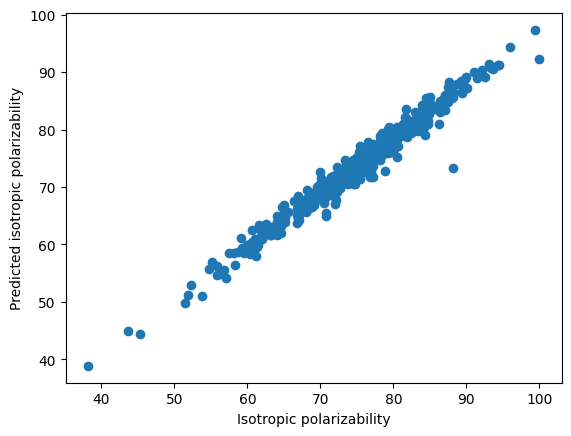

In [17]:
import matplotlib.pyplot as plt


plt.scatter(real[:500],predictions[:500])
plt.ylabel('Predicted isotropic polarizability')
plt.xlabel('Isotropic polarizability')
#plt.savefig('figures/18_12.png', dpi=300)

## 기타 GNN 층 및 최근 개발 사항

### 스펙트럼 그래프 합성곱

### 풀링

In [18]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch18/figures/18_13.png', width=600)

### 정규화

### 그외 고급 그래프 신경망

## 요약